In [1]:
import sys
sys.path.append("../../") 
sys.path.append("../") 

In [2]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import max_error, mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from modelos import *
from matplotlib import pyplot as plt

In [3]:
def calcular_metricas(y_true, y_predict):
    return {
        "MAX_ERROR": max_error(y_true, y_predict),
        "MEAN_SQ_ERROR": mean_squared_error(y_true, y_predict),
        "MEDIAN_ABS_ERROR": median_absolute_error(y_true, y_predict),
        "MEAN_ABS_ERROR": mean_absolute_error(y_true, y_predict),
    }

In [4]:
def heuristica(Vviento):
    """Definimos la heurística basada en la Escala de Beaufort"""
    if Vviento < 3:
        return 0.4
    elif Vviento < 7:
        return 0.6
    elif Vviento < 12:
        return 1
    elif Vviento < 20:
        return 1.5
    elif Vviento < 26:
        return 2
    elif Vviento < 36:
        return 2.5
    elif Vviento < 46:
        return 3.2
    elif Vviento < 56:
        return 4.2
    elif Vviento < 66:
        return 5.4
    elif Vviento < 76:
        return 6.5
    elif Vviento < 88:
        return 8
    elif Vviento < 101:
        return 10
    elif Vviento >= 101:
        return 12

## Datos nuevos

Cargamos los datos que hemos capturado hasta ahora

In [23]:
data = pd.read_csv("./clean/forecast_merged.csv")
data = data.dropna() 
# Quitamos todas aquellas filas que tengan algun na para tener filas con la altura de olas sabida

In [24]:
X = data.drop(columns = "AlturaOlas")
X = X.drop(columns=["antelacion", 'anio', 'mes', 'dia', 'hora'])
y = data["AlturaOlas"]
X_model = X.copy()

Obtenemos la escala que hemos utilizado para entrenar el modelo

In [25]:
filename = '../modelos/modelo_definitivo/scaler.pkl'

with open(filename, 'rb') as file:
    scaler = pickle.load(file)

scaler

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle es

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['moonphase', 'temp', 'dewPt', 'heat_index',
                                  'rh', 'pressure', 'vis', 'wc', 'feels_like',
                                  'uv_index', 'Vviento', 'PeriodoOlas',
                                  'Lluvia', 'Nubosidad'])])

In [26]:
X_model = scaler.transform(X_model)

Cargamos el modelo para poder comparar con la heuristica

In [27]:
with open("../modelos/modelo_definitivo/modelo_rf_def.pkl", 'rb') as file:
    model = pickle.load(file)
model

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


RandomForestRegressor(max_depth=28, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=201, random_state=777)

Realizamos las predicciones

In [28]:
predicciones_modelo = model.predict(X_model)
predicciones_heuristica = X["Vviento"].apply(heuristica)

Analizamos los resultados

In [29]:
calcular_metricas(y, predicciones_modelo)

{'MAX_ERROR': 0.6023284875710251,
 'MEAN_SQ_ERROR': 0.03145840081958235,
 'MEDIAN_ABS_ERROR': 0.10592517073860375,
 'MEAN_ABS_ERROR': 0.13407054086005218}

In [30]:
calcular_metricas(y, predicciones_heuristica)

{'MAX_ERROR': 0.6,
 'MEAN_SQ_ERROR': 0.07000000000000002,
 'MEDIAN_ABS_ERROR': 0.09999999999999998,
 'MEAN_ABS_ERROR': 0.1978723404255319}

In [36]:
datos = []
item = calcular_metricas(y, predicciones_heuristica)
item['MET'] = 'HEUR'
datos.append(item)
    
item = calcular_metricas(y, predicciones_modelo)
item['MET'] = 'MODEL'
datos.append(item)

pd.DataFrame(datos)

,MAX_ERROR,MEAN_SQ_ERROR,MEDIAN_ABS_ERROR,MEAN_ABS_ERROR,MET
0,0.600000,0.070000,0.100000,0.197872,HEUR
1,0.602328,0.031458,0.105925,0.134071,MODEL


Text(0.5, 0, 'TRUE (metros)')

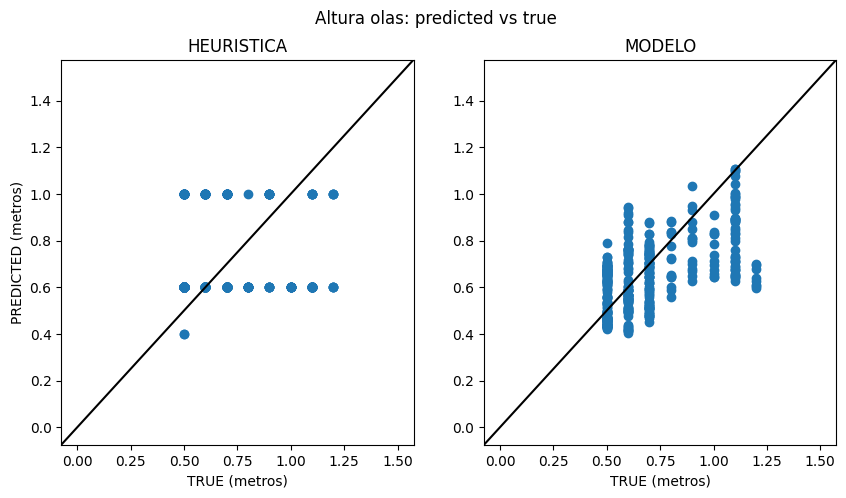

In [31]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Altura olas: predicted vs true')
## HEURISTICA
axs[0].scatter(y, predicciones_heuristica)
#axs[0].set_xticks([i/10 for i in range(0,16)])
#axs[0].set_yticks([i/10 for i in range(0,16)])
axs[0].axline([0,0], [1.5, 1.5], color='0')
axs[0].set_title('HEURISTICA')

axs[0].set_ylabel('PREDICTED (metros)')
axs[0].set_xlabel('TRUE (metros)')

## MODELO
axs[1].scatter(y, predicciones_modelo)
#axs[0].set_xticks([i/10 for i in range(0,16)])
#axs[0].set_yticks([i/10 for i in range(0,16)])
axs[1].axline([0,0], [1.5, 1.5], color='0')
axs[1].set_title('MODELO')

axs[1].set_xlabel('TRUE (metros)')

Como podemos observar el modelo nuestro se comporta algo mejor que la heurística, pero se comporta de manera parecida en general. Que nuestro modelo se comporte parecido a la heurística es algo que no teníamos previsto pero puede darse por el hecho de predecir la altura de las olas a partir de predicciones, o por el hecho de que hasta el momento tenemos muy pocos datos recolectados de predicciones.

#### Comparamos por segmentos

In [32]:
def class_ola(ola):
    if (ola < 1):
        return "x<1"
    if (ola < 2):
        return "1<x<2"
    if (ola < 3):
        return "2<x<3"
    else:
        return "x>3"

In [35]:
datos = []
for segm in y.map(class_ola).unique():
    filtro = y.map(class_ola) == segm
    item = calcular_metricas(y[filtro], predicciones_heuristica[filtro])
    item['SEG'] = segm
    item['MET'] = 'HEUR'
    datos.append(item)
    
    item = calcular_metricas(y[filtro], predicciones_modelo[filtro])
    item['SEG'] = segm
    item['MET'] = 'MODEL'
    datos.append(item)

pd.DataFrame(datos)

,MAX_ERROR,MEAN_SQ_ERROR,MEDIAN_ABS_ERROR,MEAN_ABS_ERROR,SEG,MET
0,0.500000,0.043164,0.100000,0.151412,x<1,HEUR
1,0.342307,0.016035,0.082906,0.103460,x<1,MODEL
2,0.600000,0.207681,0.500000,0.436232,1<x<2,HEUR
3,0.602328,0.110589,0.286360,0.291114,1<x<2,MODEL


Vemos que la heuristica gana de forma "significativa" solo en el ECM para olas casi inaprecables.

In [16]:
y.max()

1.2

Como se puede observar, las olas de los días que hemos recolectado son muy bajas y ese puede ser el motivo por el cual la heurística tiene tan buen rendimiento.
Por eso vamos a medir el rendimiento de la heurística con los datos reales históricos. De esta manera la heurística va a tener que predecir datos de todos los tipos y no únicamente olas bajas.

## Datos históricos


##### Probamos con todos los datos para ver si los mejores resultados de la heurística se deben al pequeño número de datos del que disponemos

In [17]:
X, y = datos_full()
X = X.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])
predicciones_heuristica = X["Vviento"].apply(heuristica)

In [18]:
calcular_metricas(y, predicciones_heuristica)

{'MAX_ERROR': 4.4,
 'MEAN_SQ_ERROR': 0.48961046057767366,
 'MEDIAN_ABS_ERROR': 0.3999999999999999,
 'MEAN_ABS_ERROR': 0.5072209211553473}

Text(0.5, 0, 'TRUE (metros)')

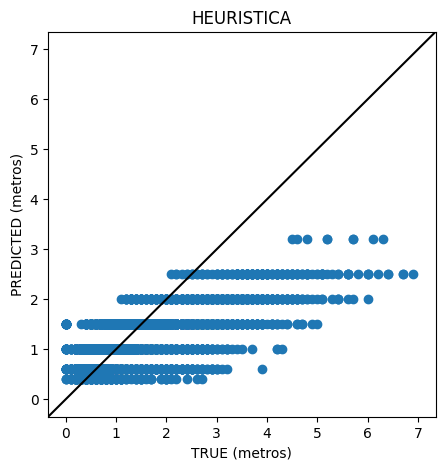

In [19]:
## HEURISTICA
plt.figure(figsize=(5,5))
plt.scatter(y, predicciones_heuristica)
#axs[0].set_xticks([i/10 for i in range(0,16)])
#axs[0].set_yticks([i/10 for i in range(0,16)])
plt.axline([0,0], [7, 7], color='0')
plt.title('HEURISTICA')

plt.ylabel('PREDICTED (metros)')
plt.xlabel('TRUE (metros)')

Se puede observar que nuestra heurística funciona mucho peor en el momento en el que se encuentra con una variedad de datos muy grande.

Ahora bien, no sabemos cómo se comporta nuestro modelo para estos datos. Podemos suponer que bien, porque en su momento entrenamos el modelo con datos da train y en el test había un buen rendimiento, pero no podemos asegurarlo.

A partir de aquí tenemos dos opciones, medir el rendimiento con muchos datos de predicciones por los cuales tenemos que esperar a los correspondientes datos reales, y por otro lado, sacar datos reales de 2024 y medir el rendimiento del modelo global en esos datos.

